# 1). Set Up the Environment

In [2]:
#import base libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# import train dataset
train_data = pd.read_json("review-Vermont_10.json", lines=True)
advertisements_data = pd.read_json("advertisements.json")
irrelevant_data = pd.read_json("irrelevant.json")
rant_data = pd.read_json("rant_without_visit.json")

# 2). Exploratory Data Analysis

In [4]:
# Visualise the train dataset...
print("\n----------FIRST FIVE INSTANCES IN TRAIN----------\n")
display(train_data.head())
print("\n----------TRAIN DATA INFORMATION----------\n")
display(train_data.info())
print("\n----------TRAIN DATA SUMMARY STATS----------\n")
display(train_data.describe())


----------FIRST FIVE INSTANCES IN TRAIN----------



,user_id,name,time,rating,text,pics,resp,gmap_id
0,1.180269e+20,rebecca kerns,1620085852324,5,Always done right from wood stove to screens!,None,"{'time': 1620087641504, 'text': 'Good Evening,...",0x89e02445cb9db457:0x37f42bff4edf7a43
1,1.015327e+20,Peter DeForge,1580309946474,5,A great company to work with. Their sales and...,None,"{'time': 1580320228721, 'text': 'Good Afternoo...",0x89e02445cb9db457:0x37f42bff4edf7a43
2,1.154041e+20,Chad Goulette,1605195974445,5,Great place to do business with staff was grea...,None,"{'time': 1605195166792, 'text': 'Hi Chad! Tha...",0x89e02445cb9db457:0x37f42bff4edf7a43
3,1.047893e+20,Mark LaFountain,1593005848256,5,"Awesome Customer service, quick response, and ...",None,"{'time': 1593376422014, 'text': 'Mark, thank y...",0x89e02445cb9db457:0x37f42bff4edf7a43
4,1.089807e+20,Jeff R,1582059996120,5,"If you need a top quality job, by a group of p...",None,"{'time': 1582063833737, 'text': 'Good Afternoo...",0x89e02445cb9db457:0x37f42bff4edf7a43



----------TRAIN DATA INFORMATION----------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 324725 entries, 0 to 324724
Data columns (total 8 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   user_id  324725 non-null  float64
 1   name     324725 non-null  object 
 2   time     324725 non-null  int64  
 3   rating   324725 non-null  int64  
 4   text     178168 non-null  object 
 5   pics     9651 non-null    object 
 6   resp     26838 non-null   object 
 7   gmap_id  324725 non-null  object 
dtypes: float64(1), int64(2), object(5)
memory usage: 19.8+ MB


None


----------TRAIN DATA SUMMARY STATS----------



,user_id,time,rating
count,3.247250e+05,3.247250e+05,324725.000000
mean,1.091867e+20,1.548171e+12,4.314346
std,5.313166e+18,3.945905e+10,0.996339
min,1.000018e+20,1.182960e+12,1.000000
25%,1.045707e+20,1.523215e+12,4.000000
50%,1.091955e+20,1.550804e+12,5.000000
75%,1.137058e+20,1.573925e+12,5.000000
max,1.184442e+20,1.631106e+12,5.000000



Key Takeaways

- Columns with missing data in the train dataset: text, pics and resp
- Train dataset contains 324725 examples with 8 variables

2a). Histograms and Correlation Matrix for all numeric variables

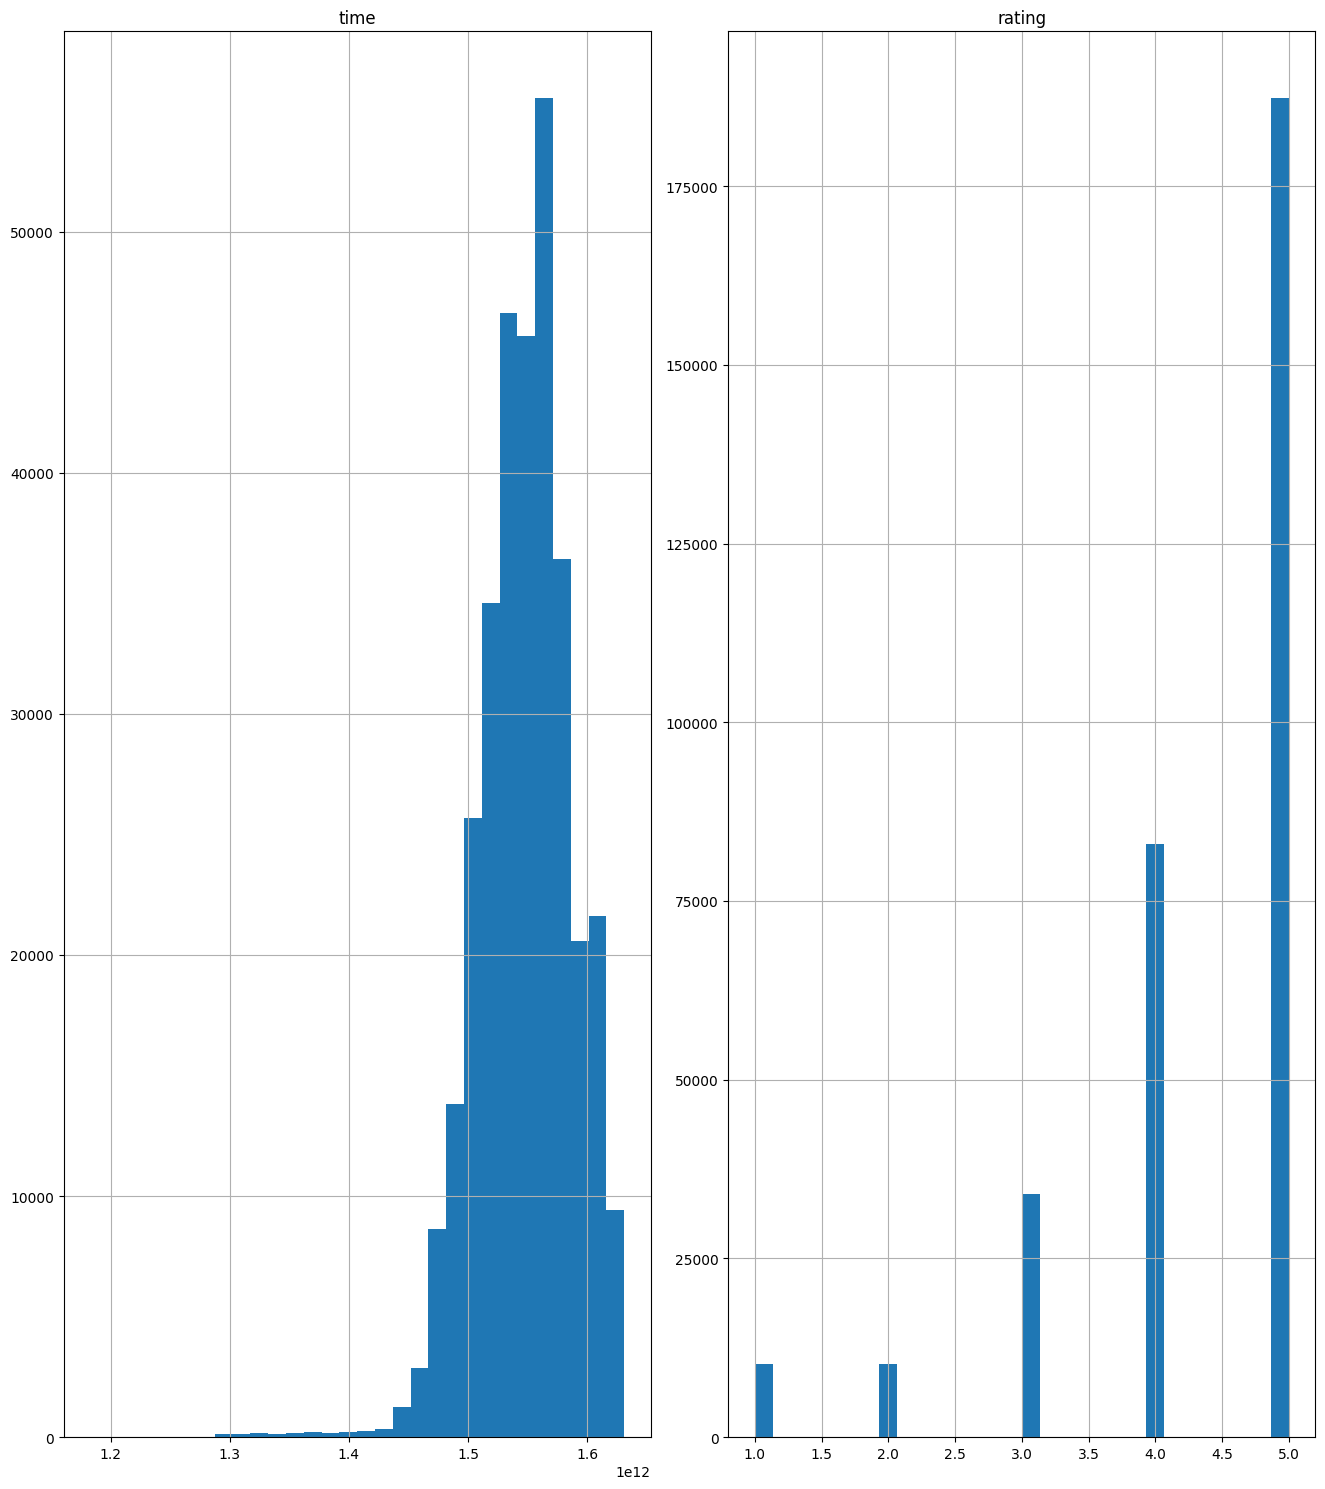

In [6]:

# Drop id variable
train_data_v2 = train_data.copy()
train_data_v2.drop(["user_id"], axis=1, inplace=True)

# Plot histograms for all numeric columns
train_data_v2.hist(figsize=(20, 15), bins=30, layout=(-1, 3))  # Adjust layout based on # of columns
plt.tight_layout()
plt.show()

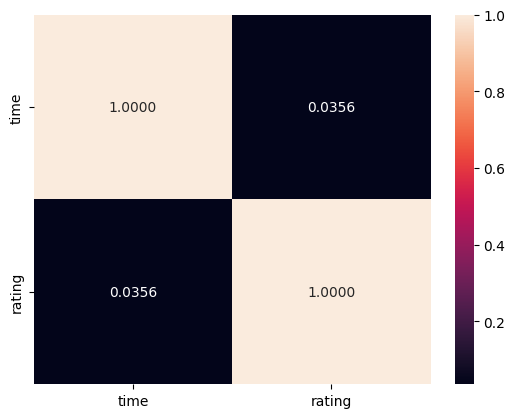

In [7]:
# Correlation Matrix
sns.heatmap(
    train_data_v2.select_dtypes(include=np.number).corr(),
    annot=True,
    fmt=".4f"
)
plt.show()

# 3). Feature Engineering

New features engineered from the existing dataset:

*   **`has_pics`**: A binary flag indicating if the reviewer has posted a pic.
*   **`has_text`**: A binary flag indicating if the reviewer has
*   **`has_resp`**: A binary flag indicating if the reviewer has
*   **`resp_time`**: 
*   **`resp_text`**: 
*   **`???`**: difference between time and resp_time
*   **`review_length`**:
*   You can use a geocoding API (like Google's Geocoding API or a cheaper alternative like OpenStreetMap's Nominatim) to convert the gmap_id or business name into a physical address (city, state, country).
    - If a user has reviewed a diverse set of businesses (e.g., a restaurant in New York, a dentist in Los Angeles, and a park in London) all within a short time span, this is a major red flag for a spammer or fake reviewer. A genuine user typically reviews places in a geographically coherent area.
*   **`business_type`**: needs geocoding api

# 4). Preprocessing and Modeling 

In [4]:
# preprocessing
genuine_texts = [item for item in train_data[:500]["text"] if item is not None]
#print(train_data_subset[:50]) # all low according to deepseek r1

ad_reviews_list = advertisements_data["reviews"]
# Extract the 'text' from each dictionary in the list
ad_texts = [review["text"] for review in ad_reviews_list]

irre_reviews_list = irrelevant_data["reviews"]
# Extract the 'text' from each dictionary in the list
irre_texts = [review["text"] for review in irre_reviews_list]

rant_reviews_list = rant_data["reviews"]
# Extract the 'text' from each dictionary in the list
rant_texts = [review["text"] for review in rant_reviews_list]

# Construct our evaluation dataset
columns=['text', 'ad_score', 'irre_score', 'rant_score']
data = []
for text in genuine_texts[:50]:
    data.append([text, 0, 0, 0])
for text in ad_texts[:50]:
    data.append([text, 1, 0, 0])
for text in irre_texts[:50]:
    data.append([text, 0, 1, 0])
for text in rant_texts[:50]:
    data.append([text, 0, 0, 1])
evaluation_df = pd.DataFrame(data, columns=columns).sample(frac=1.0, random_state=42)
print(evaluation_df)
X, y = evaluation_df["text"], evaluation_df.drop(columns=["text"])


                                                  text  ad_score  irre_score  \
95   I got my eyes checked at VisionPlus. The exam ...         1           0   
15   Always friendly service. Honest and profession...         0           0   
30   I have been a propane customer with Keyser Ene...         0           0   
158  The reviews don't lie. This is the most overra...         0           0   
128  I'm thinking about getting bangs. My last hair...         0           1   
..                                                 ...       ...         ...   
106  My mother-in-law is coming to visit for two we...         0           1   
14   Brent is very friendly and always willing to h...         0           0   
92   The cupcakes at Sweet Treats Bakery are delici...         1           0   
179  An embarrassment to the industry. They set the...         0           0   
102  I prefer the taste of name-brand ketchup over ...         0           1   

     rant_score  
95            0  
15 

In [5]:
import ollama
import re
import json

In [ ]:
# Start with the initial prompt
batch_size = 10

content = """
You are an expert review classifier. Your task is to analyze user reviews and assign a confidence level for three specific categories: "advertisement", "irrelevant", and "rant without visit".

**Categories & Examples:**
-   **advertisement**: "Best pizza! Visit www.pizzapromo.com for discounts!"
-   **irrelevant**: "I love my new phone, but this place is too noisy."
-   **rant without visit**: "Never been here, but i heard it's terrible."

**Input:**
A list of reviews.

**Task:**
For the provided reviews, analyze the text, user, and business response fields to determine a confidence level (Low, or High) for each category.

**Output Instructions:**
- **DO NOT** include any other text, explanations, or commentary before or after the JSON.
- **DO NOT** include a `reviews` or any other key for the main JSON array.
- The output must be a single JSON array `[]` containing one JSON object `{}` for each review.
- Each object must have exactly three keys: `"advertisement"`, `"irrelevant"`, and `"rant without visit"`.
- Each value must be one of the strings: `"Low"` or `"High"`.
- The format must be identical to the example output.

**Example Input:**
"Well they did a bang up job, can't complain! Thank you, Mid-State for your hospitality and your service!", "Awesome place to get a car!!"

**Example Output:**
```json
[
  {
    "advertisement": "Low",
    "irrelevant": "Low",
    "rant without visit": "Low"
  },
  {
    "advertisement": "Low",
    "irrelevant": "Low",
    "rant without visit": "Low"
  }
]
"""
messages=[
    {'role': 'user', 'content': content}
]

# 2. Make the first call
response1 = ollama.chat(model='deepseek-r1:14b', messages=messages) # requires the model to be installed locally in ollama

# 3. Append the model's response to the message history
messages.append({'role': 'assistant', 'content': response1['message']['content']})

pred_data = []
columns = ['ad_score', 'irre_score', 'rant_score']
y_pred = pd.DataFrame(pred_data, columns=columns)
for i in range(0, 200, batch_size): #len(evaluation_df)
  # 4. Add the next user prompt to test reviews
  content2 = ", ".join([f'"{item}"' for item in X[i:i+batch_size]])
  print(content2)
  print("content2 len ", len([f'"{item}"' for item in X[i:i+batch_size]]))
  print(i, i+batch_size)
  messages.append({'role': 'user', 'content': content2})

  # 5. Make the second call, passing the entire updated message list
  response2 = ollama.chat(model='deepseek-r1:14b', messages=messages)

  print(response2['message']['content'])

  try:
    json_string = re.search(r'```json(.*?)```', response2['message']['content'], re.DOTALL).group(1)
    json_data = json.loads(json_string)
  except AttributeError as e: # repeat if the model dont output correctly
    print("attribute_error")
    i -= batch_size
    continue

  # convert low/high to binary classification
  cat_to_num = {"Low": 0, "High": 1}
  converted_data = [{k: cat_to_num[v] for k, v in d.items()} for d in json_data]

  for entry in converted_data:
    y_pred.loc[len(y_pred)] = [entry["advertisement"], entry["irrelevant"], entry["rant without visit"]]

  messages.pop() # remove the previous message

"I got my eyes checked at VisionPlus. The exam was thorough, but I saved over $200 on my glasses by ordering them from Zenni Optical online. Their prices start at just $6.95! Go to zennioptical.com and enter code VISIONPLUS for 10% off your first order. Unbeatable prices!", "Always friendly service. Honest and professional service handlers", "I have been a propane customer with Keyser Energy since 2014.  In that time I have found them to provide clear and helpful communication, contracting, and delivery service.  This year I had a furnace malfunction which they masterfully resolved.", "The reviews don't lie. This is the most overrated and disappointing place I've ever had the misfortune of encountering. A total scam and a waste of time.", "I'm thinking about getting bangs. My last haircut was a disaster, so I'm a bit nervous.", "The city needs to fix the pothole on my street. It's deep enough to swallow a small car.", "The coffee at Brewsters is a bit weak. What really perked me up was

In [7]:
#evaluate the pred
from sklearn.metrics import precision_score, recall_score, f1_score

y_truth = y[:20]
print(y_pred)
print(y_truth)

for category in y_truth.columns:
    print(f"--- Metrics for {category} ---")

    true_labels = y_truth[category]
    pred_labels = y_pred[category]

    precision = precision_score(true_labels, pred_labels)
    recall = recall_score(true_labels, pred_labels)
    f1 = f1_score(true_labels, pred_labels)

    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1-Score: {f1:.2f}\n")



    ad_score  irre_score  rant_score
0          1           0           0
1          0           0           0
2          0           0           0
3          0           0           1
4          0           1           0
5          0           1           0
6          1           0           0
7          0           0           0
8          0           0           1
9          0           0           0
10         1           0           0
11         0           0           1
12         0           0           1
13         1           0           0
14         0           0           1
15         0           0           1
16         1           0           0
17         0           0           1
18         1           0           0
19         1           0           0
     ad_score  irre_score  rant_score
95          1           0           0
15          0           0           0
30          0           0           0
158         0           0           1
128         0           1        